# Histopathologic Cancer Detection

## Check GPU availability

In [3]:
# To use GPU, follow this tutorial: https://www.youtube.com/watch?v=tPq6NIboLSc&t=1s

from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
    
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


TensorFlow Version: 2.1.0
Default GPU Device: /device:GPU:0
Num GPUs Available:  1


## Libraries

In [4]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd 
from tqdm import tqdm
from skimage.io import imread
from glob import glob

from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split

from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

#VGG16
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

#from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.nasnet import NASNetMobile
from keras.applications.xception import Xception
from keras.utils.vis_utils import plot_model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D
from keras.models import Model
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam

## Data Directory

In [5]:
input_dir = '/Users/ACER/Desktop/hpc_dataset/'
cropped_train_dir = input_dir + 'cropped_train/'
cropped_val_dir = input_dir + 'cropped_val/'

## Data normalization and generation

In [8]:
# Data normalization
training_data_generator = ImageDataGenerator(rescale=1./255)

In [9]:
# Data normalization
val_data_generator = ImageDataGenerator(rescale=1./255)

In [10]:
# Data generation
training_generator = training_data_generator.flow_from_directory(cropped_train_dir,
                                                                 target_size=(48,48),
                                                                 batch_size=32,
                                                                 class_mode='binary')

Found 176020 images belonging to 2 classes.


In [11]:
validation_generator = val_data_generator.flow_from_directory(cropped_val_dir,
                                                              target_size=(48,48),
                                                              batch_size=32,
                                                              class_mode='binary')

Found 44005 images belonging to 2 classes.


## Model Building and Training

In [12]:
def VGG16_model():
    base_model = VGG16(include_top=False,
                       input_shape = (48,48,3),
                       weights = 'imagenet')
    
    model = Sequential()
    model.add(base_model)
    
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(512,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation='sigmoid'))
    #model.layers[0].trainable=False
    model.summary()
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(lr=0.0001, decay=0.00001),
                  metrics=['acc'] )
    return model

In [13]:
model = VGG16_model()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 513       
Total params: 14,977,857
Trainable params: 14,977,857
Non-trainable params: 0
__________________________________________

In [14]:
model_file = "models/model_v28.h5"

checkpoint = ModelCheckpoint(model_file, monitor='val_acc',
                             verbose=1, save_best_only=True,
                             mode='max', save_weights_only=False, 
                             period=1)

earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001,
                          patience=10, verbose=1, 
                          mode='auto')

history = model.fit_generator(training_generator,
                              steps_per_epoch=len(training_generator), 
                              validation_data=validation_generator,
                              validation_steps=len(validation_generator),
                              epochs=10,
                              verbose=1,
                              callbacks=[checkpoint])

Epoch 1/10
5501/5501 [==============================] - 1988s 361ms/step - loss: 0.3676 - acc: 0.8428 - val_loss: 0.2222 - val_acc: 0.8755

Epoch 00001: val_acc improved from -inf to 0.87549, saving model to models/model_v28.h5
Epoch 2/10
5501/5501 [==============================] - 2005s 364ms/step - loss: 0.2739 - acc: 0.8906 - val_loss: 0.1939 - val_acc: 0.8965

Epoch 00002: val_acc improved from 0.87549 to 0.89647, saving model to models/model_v28.h5
Epoch 3/10
5501/5501 [==============================] - 2170s 394ms/step - loss: 0.2346 - acc: 0.9075 - val_loss: 0.1995 - val_acc: 0.9031

Epoch 00003: val_acc improved from 0.89647 to 0.90306, saving model to models/model_v28.h5
Epoch 4/10
5501/5501 [==============================] - 1966s 357ms/step - loss: 0.1984 - acc: 0.9235 - val_loss: 0.3441 - val_acc: 0.9026

Epoch 00004: val_acc did not improve from 0.90306
Epoch 5/10
5501/5501 [==============================] - 1922s 349ms/step - loss: 0.1593 - acc: 0.9397 - val_loss: 0.0245

## Training Plot

Text(0, 0.5, 'loss')

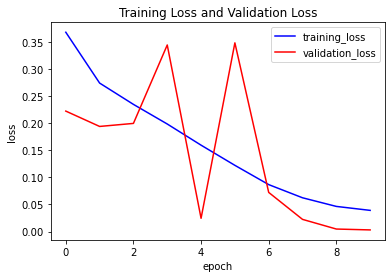

In [15]:
# Plot Training and Validation Loss
plt.plot(history.history['loss'], color='blue', label="training_loss")
plt.plot(history.history['val_loss'], color='red', label="validation_loss")
plt.legend(loc='best')
plt.title('Training Loss and Validation Loss')
plt.xlabel('epoch')
plt.ylabel('loss')

Text(0, 0.5, 'accuracy')

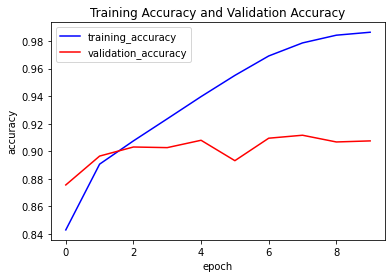

In [16]:
# Plot Training and Validation Accuracy
plt.plot(history.history['acc'], color='blue', label="training_accuracy")
plt.plot(history.history['val_acc'], color='red',label="validation_accuracy")
plt.legend(loc='best')
plt.title('Training Accuracy and Validation Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')

Found 44005 images belonging to 2 classes.
1376/1376 [==============================] - 99s 72ms/step


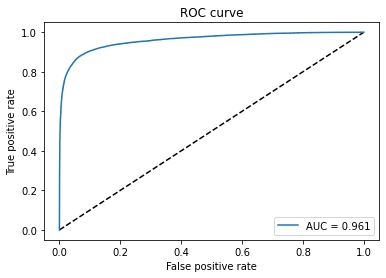

In [21]:
# ROC testing plot
model = load_model(model_file)

roc_validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(cropped_val_dir,
                                                                                  target_size=(48,48),
                                                                                  batch_size=32,
                                                                                  class_mode='binary',
                                                                                  shuffle=False)

predictions = model.predict_generator(roc_validation_generator, steps=len(roc_validation_generator), verbose=1)
false_positive_rate, true_positive_rate, threshold = roc_curve(roc_validation_generator.classes, predictions)
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.show()

In [22]:
# Calculate Validation Precision, Recall, and Accuracy 

predictions_list = predictions.tolist()
predict = []

for i in predictions_list:
    for j in i:
        j = round(j)
        predict.append(j)


tn, fp, fn, tp = confusion_matrix(validation_generator.classes, predict).ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)
accuracy = (tp+tn)/(tp+fp+tn+fn)

print("Validation Precision: " + str(precision))
print("Validation Recall: " + str(recall))
print("Validation Accuracy: " + str(accuracy))

Validation Precision: 0.9051188193597118
Validation Recall: 0.8734510793383796
Validation Accuracy: 0.9116009544369958


## Generate test prediction CSV file 

In [23]:
model_file = "models/model_v28.h5"
model = load_model(model_file)

from skimage.io import imread
from glob import glob
from tqdm import tqdm

testing_batch_size = 1000

testing_files = glob(os.path.join('/Users/ACER/Desktop/hpc_dataset/cropped_test/','*.tif'))
submission = pd.DataFrame()
for index in tqdm(range(0, len(testing_files), testing_batch_size)):
    data_frame = pd.DataFrame({'path': testing_files[index:index+testing_batch_size]})
    data_frame['id'] = data_frame.path.map(lambda x: x.split('/')[5].split(".")[0])
    data_frame['image'] = data_frame['path'].map(imread)
    images = np.stack(data_frame.image, axis=0)
    predicted_labels = [model.predict(np.expand_dims(image/255.0, axis=0))[0][0] for image in images]
    predictions = np.array(predicted_labels)
    data_frame['label'] = predictions
    submission = pd.concat([submission, data_frame[["id", "label"]]])
submission.to_csv("submission_ar_28.csv", index=False, header=True)

100%|██████████████████████████████████████████| 58/58 [42:18<00:00, 43.77s/it]


To see the test accuracy, submit the CSV file to this link:
https://www.kaggle.com/c/histopathologic-cancer-detection/submit